Nice way to visualize toy networks:
https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.62505&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

In [1]:
% load_ext autoreload
% autoreload 2

UsageError: Line magic function `%` not found.


In [2]:
### Classification
import torch
from torch import nn

import sklearn
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from helper_functions import plot_decision_boundary, plot_predictions

In [3]:
n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

X.shape, y.shape

((1000, 2), (1000,))

In [4]:
X.dtype

dtype('float64')

In [5]:
y.dtype

dtype('int64')

In [6]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

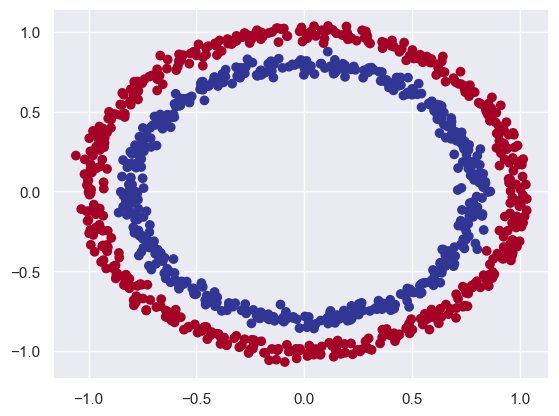

In [7]:
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "y": y})
# circles

plt.scatter(circles["X1"], circles["X2"], c=circles["y"], cmap=plt.cm.RdYlBu)

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.dtype

torch.float32

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
len(X_train), len(X_test)

(800, 200)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer2(self.layer1(x))
    
model_0 = CircleModelV0().to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

In [13]:
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

In [14]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5550, -0.6698],
                      [ 0.1723,  0.3525],
                      [-0.0930, -0.0361],
                      [ 0.1129, -0.2661],
                      [-0.1018,  0.5797]], device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.3674, -0.4072, -0.4513,  0.1963, -0.1693], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.1355, -0.3718,  0.2949,  0.3473, -0.2641]], device='cuda:0')),
             ('layer2.bias', tensor([-0.0036], device='cuda:0'))])

In [15]:
model_0.eval()
with torch.inference_mode():
    untrained_preds = model_0(X.to(device))
    
untrained_preds[:10]

tensor([[-0.0666],
        [ 0.1085],
        [ 0.1085],
        [-0.0880],
        [ 0.2992],
        [-0.0745],
        [-0.1590],
        [-0.0436],
        [ 0.3301],
        [-0.2128]], device='cuda:0')

In [16]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [17]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    return torch.eq(y_true, y_pred).sum().item() / len(y_pred)

In [18]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))
    
y_logits[:5]

tensor([[-0.0868],
        [-0.2083],
        [ 0.2418],
        [-0.1800],
        [ 0.2579]], device='cuda:0')

In [19]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [20]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.4783],
        [0.4481],
        [0.5602],
        [0.4551],
        [0.5641]], device='cuda:0')

In [21]:
torch.round(y_pred_probs)[:5]

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

In [22]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_pred_labels[:5]

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0', grad_fn=<SliceBackward0>)

In [23]:
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

### Training loop

In [24]:
y_logits[:5].dtype

torch.float32

In [25]:
y_train[:5].dtype

torch.float32

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 100

for epoch in range(epochs):
    model_0.train()
    
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (epoch + 1) % 10 == 0:
        model_0.eval()
        with torch.inference_mode():
            test_logits = model_0(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {100*acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {100*test_acc:.2f}%")
       

Epoch: 9 | Loss: 0.69871, Accuracy: 49.38% | Test Loss: 0.69075, Test Accuracy: 54.00%
Epoch: 19 | Loss: 0.69748, Accuracy: 49.25% | Test Loss: 0.69061, Test Accuracy: 53.50%
Epoch: 29 | Loss: 0.69671, Accuracy: 48.62% | Test Loss: 0.69065, Test Accuracy: 53.50%
Epoch: 39 | Loss: 0.69617, Accuracy: 48.62% | Test Loss: 0.69074, Test Accuracy: 53.50%
Epoch: 49 | Loss: 0.69575, Accuracy: 48.62% | Test Loss: 0.69084, Test Accuracy: 53.50%
Epoch: 59 | Loss: 0.69541, Accuracy: 48.50% | Test Loss: 0.69095, Test Accuracy: 53.50%
Epoch: 69 | Loss: 0.69513, Accuracy: 48.88% | Test Loss: 0.69107, Test Accuracy: 53.00%
Epoch: 79 | Loss: 0.69490, Accuracy: 48.88% | Test Loss: 0.69118, Test Accuracy: 52.50%
Epoch: 89 | Loss: 0.69470, Accuracy: 48.88% | Test Loss: 0.69130, Test Accuracy: 52.50%
Epoch: 99 | Loss: 0.69453, Accuracy: 48.88% | Test Loss: 0.69141, Test Accuracy: 53.00%


# Plot decision boundary

In [27]:
import requests
from pathlib import Path

# Download helper functons from pytorch repo 
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists. Skipping download.")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", mode="wb") as f:
        f.write(request.content)


helper_functions.py already exists. Skipping download.


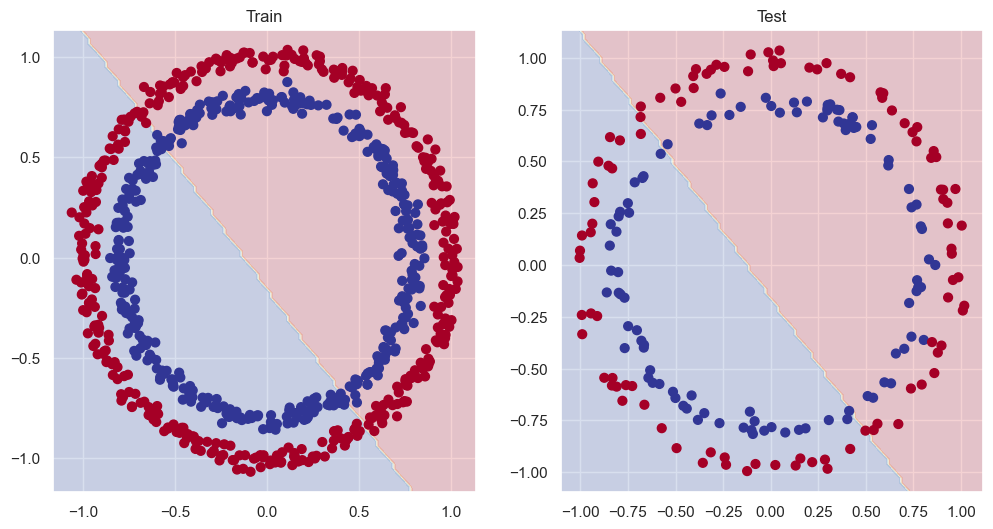

In [28]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Improving the model

In [29]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer3(self.layer2(self.layer1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [31]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [32]:
X_train.device

device(type='cuda', index=0)

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_1.train()
    
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (epoch + 1) % 10 == 0:
        model_1.eval()
        with torch.inference_mode():
            test_logits = model_1(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {100*acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {100*test_acc:.2f}%")
       

Epoch: 9 | Loss: 0.69371, Accuracy: 50.00% | Test Loss: 0.69269, Test Accuracy: 50.00%
Epoch: 19 | Loss: 0.69353, Accuracy: 50.25% | Test Loss: 0.69282, Test Accuracy: 49.50%
Epoch: 29 | Loss: 0.69340, Accuracy: 50.38% | Test Loss: 0.69295, Test Accuracy: 48.50%
Epoch: 39 | Loss: 0.69330, Accuracy: 50.38% | Test Loss: 0.69309, Test Accuracy: 48.50%
Epoch: 49 | Loss: 0.69323, Accuracy: 49.88% | Test Loss: 0.69322, Test Accuracy: 49.50%
Epoch: 59 | Loss: 0.69317, Accuracy: 49.38% | Test Loss: 0.69335, Test Accuracy: 53.00%
Epoch: 69 | Loss: 0.69313, Accuracy: 49.38% | Test Loss: 0.69347, Test Accuracy: 50.50%
Epoch: 79 | Loss: 0.69309, Accuracy: 50.00% | Test Loss: 0.69358, Test Accuracy: 51.00%
Epoch: 89 | Loss: 0.69307, Accuracy: 50.75% | Test Loss: 0.69369, Test Accuracy: 47.50%
Epoch: 99 | Loss: 0.69305, Accuracy: 50.62% | Test Loss: 0.69378, Test Accuracy: 49.00%
Epoch: 109 | Loss: 0.69303, Accuracy: 50.88% | Test Loss: 0.69387, Test Accuracy: 46.50%
Epoch: 119 | Loss: 0.69302, Accu

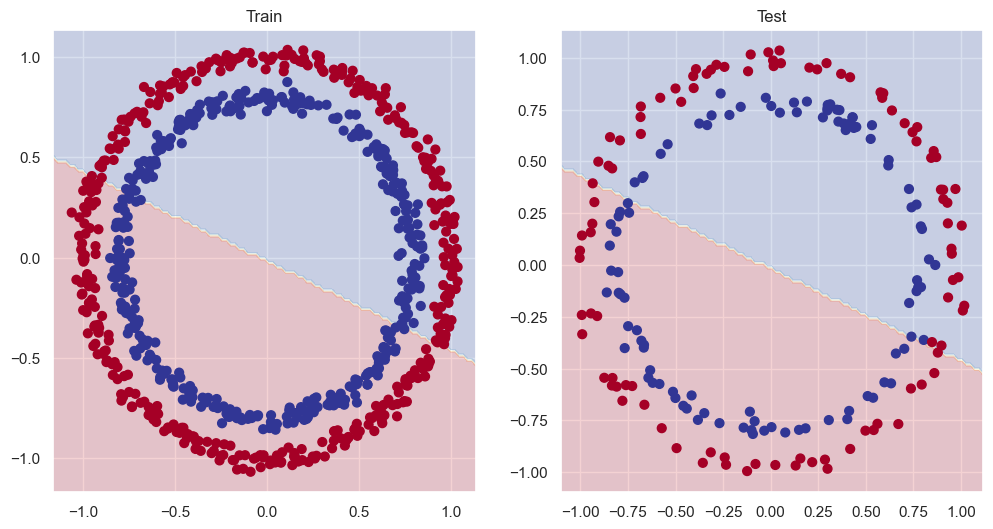

In [34]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [35]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [36]:
### Sanity check on linear model

# linear regression formula to make a linear dataset

weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias


# splitting data in training and testing datasets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train_regression, y_train_regression = X[:train_size], y[:train_size]
X_test_regression, y_test_regression = X[train_size:], y[train_size:]

print(X_train.shape, X_test.shape)

X_train_regression = X_train_regression.to(device)
y_train_regression = y_train_regression.to(device)
X_test_regression = X_test_regression.to(device)
y_test_regression = y_test_regression.to(device)

torch.Size([800, 2]) torch.Size([200, 2])


In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)


loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.001)

torch.manual_seed(42)
epochs = 1500

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model_2.train()
    train_pred = model_2(X_train_regression)
    train_loss = loss_fn(train_pred, y_train_regression)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        model_2.eval()
        with torch.inference_mode():
            test_pred = model_2(X_test_regression)
            test_loss = loss_fn(test_pred, y_test_regression)
        epoch_count.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)
        print(f'Epoch {epoch}: Loss {train_loss.item():.4f}, Test Loss {test_loss.item():.4f}')

Epoch 0: Loss 0.7599, Test Loss 0.9497
Epoch 100: Loss 0.4027, Test Loss 0.5403
Epoch 200: Loss 0.0588, Test Loss 0.1348
Epoch 300: Loss 0.0146, Test Loss 0.0334
Epoch 400: Loss 0.0031, Test Loss 0.0001
Epoch 500: Loss 0.0031, Test Loss 0.0001
Epoch 600: Loss 0.0031, Test Loss 0.0002
Epoch 700: Loss 0.0030, Test Loss 0.0001
Epoch 800: Loss 0.0030, Test Loss 0.0002
Epoch 900: Loss 0.0029, Test Loss 0.0001
Epoch 1000: Loss 0.0029, Test Loss 0.0001
Epoch 1100: Loss 0.0029, Test Loss 0.0002
Epoch 1200: Loss 0.0028, Test Loss 0.0001
Epoch 1300: Loss 0.0028, Test Loss 0.0002
Epoch 1400: Loss 0.0028, Test Loss 0.0002


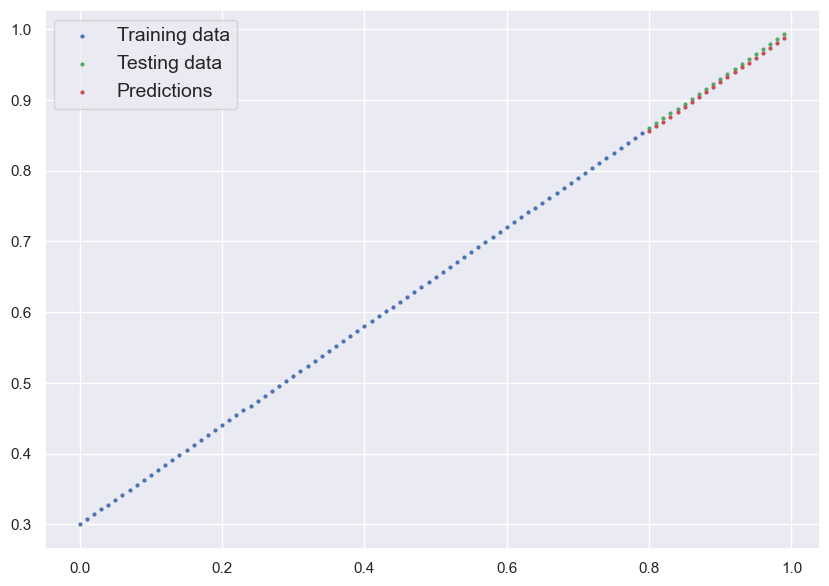

In [38]:
model_2.eval()
with torch.inference_mode():
    test_pred = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression, predictions=test_pred)

# Introducing nonlinearity

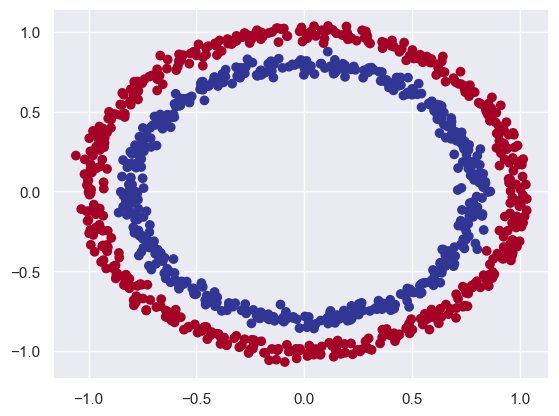

In [39]:
n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "y": y})

plt.scatter(circles["X1"], circles["X2"], c=circles["y"], cmap=plt.cm.RdYlBu)
plt.show()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [40]:

class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    
model_3 = CircleModelV3().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 2000
for epoch in range(epochs):
    model_3.train()
    
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model_3.eval()
        with torch.inference_mode():
            test_logits = model_3(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {100*acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {100*test_acc:.2f}%")

Epoch: 99 | Loss: 0.69117, Accuracy: 53.00% | Test Loss: 0.69104, Test Accuracy: 52.50%
Epoch: 199 | Loss: 0.68979, Accuracy: 53.37% | Test Loss: 0.68941, Test Accuracy: 55.00%
Epoch: 299 | Loss: 0.68797, Accuracy: 53.00% | Test Loss: 0.68726, Test Accuracy: 56.00%
Epoch: 399 | Loss: 0.68520, Accuracy: 52.75% | Test Loss: 0.68415, Test Accuracy: 56.50%
Epoch: 499 | Loss: 0.68107, Accuracy: 52.75% | Test Loss: 0.67947, Test Accuracy: 56.50%
Epoch: 599 | Loss: 0.67522, Accuracy: 54.37% | Test Loss: 0.67293, Test Accuracy: 56.00%
Epoch: 699 | Loss: 0.66670, Accuracy: 58.38% | Test Loss: 0.66333, Test Accuracy: 59.00%
Epoch: 799 | Loss: 0.65179, Accuracy: 64.00% | Test Loss: 0.64776, Test Accuracy: 67.50%
Epoch: 899 | Loss: 0.62401, Accuracy: 74.00% | Test Loss: 0.62180, Test Accuracy: 78.50%
Epoch: 999 | Loss: 0.56890, Accuracy: 87.62% | Test Loss: 0.57440, Test Accuracy: 86.50%
Epoch: 1099 | Loss: 0.48253, Accuracy: 93.50% | Test Loss: 0.50019, Test Accuracy: 90.00%
Epoch: 1199 | Loss: 0

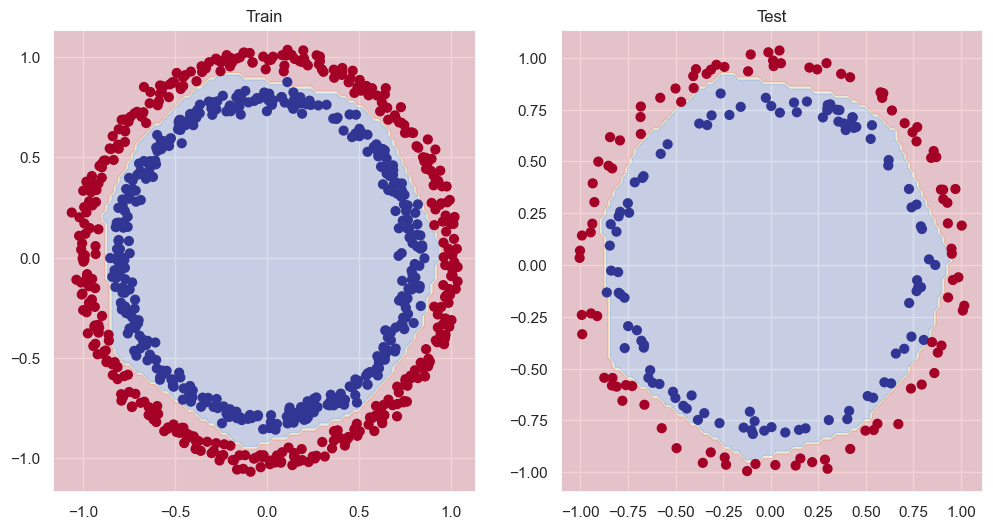

In [41]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# Multiclass clasiffication

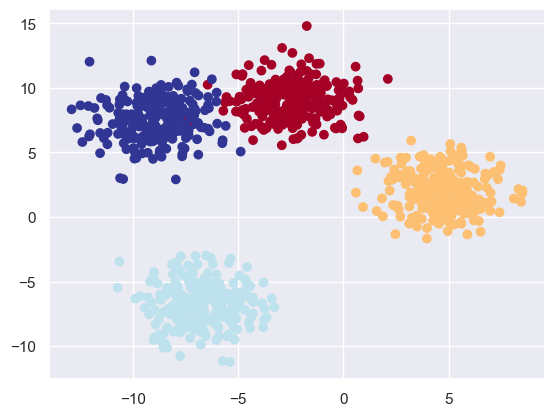

In [42]:
n_samples = 1000

X, y = make_blobs(n_samples=n_samples, 
                n_features=2,
                centers=4,
                cluster_std=1.5, 
                random_state=42)

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "y": y})

plt.scatter(circles["X1"], circles["X2"], c=circles["y"], cmap=plt.cm.RdYlBu)
plt.show()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

class ClusterModelV4(nn.Module):
    def __init__(self, input_features, output_features, hidden_units: int = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)
    
model_4 = ClusterModelV4(input_features=2, 
                         output_features=4,  
                         hidden_units=8).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 2000
for epoch in range(epochs):
    model_4.train()
    
    y_logits = model_4(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model_4.eval()
        with torch.inference_mode():
            test_logits = model_4(X_test)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {100*acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {100*test_acc:.2f}%")

Epoch: 99 | Loss: 0.03331, Accuracy: 99.25% | Test Loss: 0.02453, Test Accuracy: 99.50%
Epoch: 199 | Loss: 0.02660, Accuracy: 99.25% | Test Loss: 0.01654, Test Accuracy: 99.50%
Epoch: 299 | Loss: 0.02504, Accuracy: 99.25% | Test Loss: 0.01441, Test Accuracy: 99.50%
Epoch: 399 | Loss: 0.02428, Accuracy: 99.25% | Test Loss: 0.01336, Test Accuracy: 99.50%
Epoch: 499 | Loss: 0.02378, Accuracy: 99.25% | Test Loss: 0.01269, Test Accuracy: 99.50%
Epoch: 599 | Loss: 0.02340, Accuracy: 99.25% | Test Loss: 0.01218, Test Accuracy: 99.50%
Epoch: 699 | Loss: 0.02307, Accuracy: 99.25% | Test Loss: 0.01179, Test Accuracy: 99.50%
Epoch: 799 | Loss: 0.02279, Accuracy: 99.25% | Test Loss: 0.01147, Test Accuracy: 99.50%
Epoch: 899 | Loss: 0.02254, Accuracy: 99.25% | Test Loss: 0.01120, Test Accuracy: 99.50%
Epoch: 999 | Loss: 0.02230, Accuracy: 99.25% | Test Loss: 0.01095, Test Accuracy: 99.50%
Epoch: 1099 | Loss: 0.02208, Accuracy: 99.25% | Test Loss: 0.01073, Test Accuracy: 99.50%
Epoch: 1199 | Loss: 0

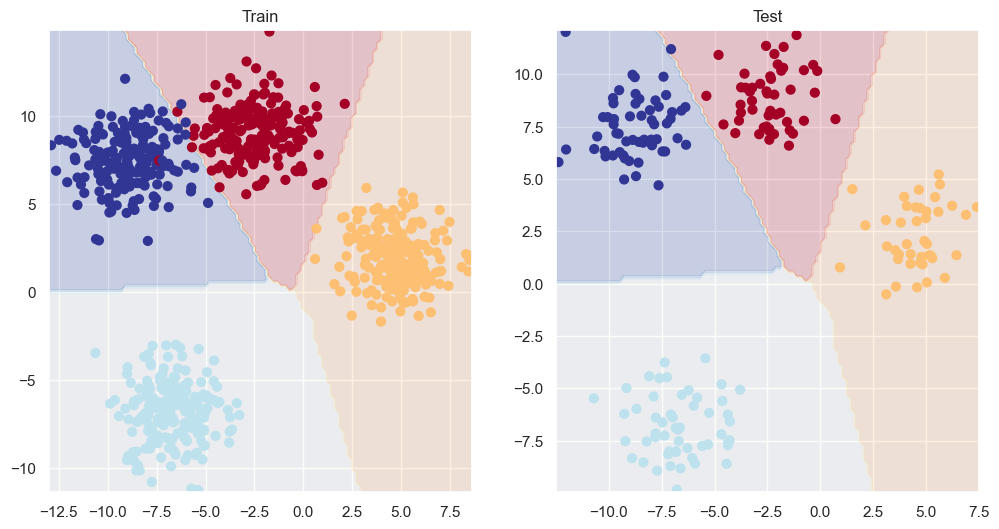

In [44]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)

### Evaluating other metrics

In [49]:
from torchmetrics import Accuracy

tmetric_acc = Accuracy(task='multiclass',
                       num_classes=4).to(device)

tmetric_acc(test_pred, y_test)



tensor(0.9950, device='cuda:0')